In [87]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from scipy import stats

In [88]:
og_df = pd.read_excel(r"E:\OneDriveFolder\OneDrive\RSA\Data\PL Data Wyscout.xlsx")
#INITIAL DATA CLEANING
#Splits the Pos column so we only have the first position listed for each player
og_df['Position'] = og_df['Position'].str.split(',').str[0].str.strip()

#INSERT 2ND POSITION COLUMN HERE - HELPS US STILL INCLUDE EDGE CASES. Then apply the mapping to both columns.

#Dictionary to map our general position categories to the more detailed wyscout ones for the purposes of our test.
position_mapping = {
    'GK': ['GK'],
    'CB': ['CB', 'LCB', 'RCB'],
    'FB': ['LB', 'RB', 'RWB', 'LWB'],
    'CM': ['DMF', 'LCMF', 'RCMF', 'LDMF', 'RDMF', 'AMF'],
    'WM': ['LW', 'RW', 'RWF', 'LWF', 'RAMF', 'LAMF'],
    'CF': ['CF']
}

# Create a reverse mapping for easy lookup e.g. LCB = CB, RWF = WM
reverse_mapping = {}
for key, values in position_mapping.items():
    for value in values:
        reverse_mapping[value] = key

# Apply the mapping
def map_position(position):
    # In case position is NaN or None
    if not isinstance(position, str):
        return position
    
    # Lookup in the reverse mapping
    return reverse_mapping.get(position, position)  # Return original if not found

#Apply Mapping
og_df['Position'] = og_df['Position'].apply(map_position)

og_df = og_df[og_df['Minutes played'] >= 500]

#Any data showing as null is assigned a 0 to prevent issues when performing calculations.
og_df = og_df.fillna(0) 

og_df

,Player,Team,Team within selected timeframe,Position,Age,Market value,Contract expires,Matches played,Minutes played,Goals,...,Prevented goals per 90,Back passes received as GK per 90,Exits per 90,Aerial duels per 90.1,Free kicks per 90,Direct free kicks per 90,"Direct free kicks on target, %",Corners per 90,Penalties taken,"Penalty conversion, %"
0,E. Haaland,Manchester City,Manchester City,CF,24.0,180000000,2034-06-30,28,2698,21,...,0.0,0.00,0.0,0.0,0.03,0.03,0.0,0.00,3,66.667
1,P. Foden,Manchester City,Manchester City,CM,24.0,150000000,2027-06-30,24,1771,7,...,0.0,0.41,0.0,0.0,0.91,0.10,50.0,2.13,0,0.000
2,B. Saka,Arsenal,Arsenal,WM,23.0,140000000,2027-06-30,16,1378,5,...,0.0,0.07,0.0,0.0,0.20,0.00,0.0,3.27,1,100.000
4,D. Rice,Arsenal,Arsenal,CM,26.0,120000000,2028-06-30,27,2368,2,...,0.0,1.29,0.0,0.0,1.41,0.04,0.0,3.08,0,0.000
5,M. Ødegaard,Arsenal,Arsenal,CM,26.0,110000000,2028-06-30,21,1856,2,...,0.0,0.63,0.0,0.0,0.87,0.10,0.0,1.60,1,100.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
491,Dean Huijsen,Bournemouth,Bournemouth,CB,19.0,0,2030-06-30,23,1914,2,...,0.0,1.50,0.0,0.0,0.00,0.00,0.0,0.00,0,0.000
492,Dango Ouattara,Bournemouth,Bournemouth,WM,23.0,0,2028-06-30,26,1706,7,...,0.0,0.11,0.0,0.0,0.00,0.00,0.0,0.11,0,0.000
493,Evanilson,Bournemouth,Bournemouth,CF,25.0,0,0,22,1646,6,...,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.00,1,0.000
495,F. Buonanotte,Leicester City,Leicester City,WM,20.0,0,2028-06-30,25,1479,4,...,0.0,0.24,0.0,0.0,0.85,0.00,0.0,1.28,0,0.000


In [89]:
#Data Transformation: CALCULATE CUSTOM METRICS. Use this cell to add any custom calculations to the data.

#EFx Aerials
EFx_AerialDuel = (og_df['Aerial duels per 90'] * og_df['Aerial duels won, %'])/100
og_df = pd.concat([og_df, EFx_AerialDuel.rename('EFx Aerial Duels')], axis=1)

#EFx Ground
EFx_GrDuel = (og_df['Defensive duels per 90'] * og_df['Defensive duels won, %'])/100
og_df = pd.concat([og_df, EFx_GrDuel.rename('EFx Ground Duels')], axis=1)
#EFx Total Duels
EFx_TotalDuel = (og_df['EFx Ground Duels'] + og_df['EFx Aerial Duels'])/100
og_df = pd.concat([og_df, EFx_TotalDuel.rename('EFx Duels')], axis=1)
#Total Duel %
sum_duels = (og_df['Aerial duels won, %'] + og_df['Defensive duels won, %'])
TotalDuelSuccess = (sum_duels/2)
og_df = pd.concat([og_df, TotalDuelSuccess.rename('Total Duel %')], axis=1)

#EFx Prog Passes
EFx_ProgPass = (og_df['Progressive passes per 90'] * og_df['Accurate progressive passes, %'])/100
og_df = pd.concat([og_df, EFx_ProgPass.rename('EFx Prog. Pass')], axis=1)

#Passes to Progressions
PassToProg = (og_df['Progressive passes per 90'] / og_df['Passes per 90'])
og_df = pd.concat([og_df, PassToProg.rename('P2P')], axis=1)

#Passes to Pen Area %
PassToPA = (og_df['Passes to penalty area per 90'] / og_df['Passes per 90'])
og_df = pd.concat([og_df, PassToPA.rename('PPA Share')], axis=1)

#Outlet Pass Marker (Passes Rec - Passes played)
outlet_passcalc = (og_df['Received passes per 90'] - og_df ['Passes per 90'])
og_df = pd.concat([og_df, outlet_passcalc.rename('OutletMarker1')], axis=1)

#Shot

#xG per Shot

In [90]:
fb_df = og_df[og_df['Position'] == 'FB']
cb_df = og_df[og_df['Position'] == 'CB']
cm_df = og_df[og_df['Position'] == 'CM']
cf_df = og_df[og_df['Position'] == 'CF']
wm_df = og_df[og_df['Position'] == 'WM']

cm_df.shape

(100, 122)

In [91]:
# Define features for CM clustering
cm_features = ['EFx Ground Duels', 'EFx Prog. Pass', 'Accurate passes, %',
               'Progressive runs per 90', 'Key passes per 90', 'Touches in box per 90']

# Check for any missing data or issues
print("Feature statistics:")
print(cm_df[cm_features].describe())
print(f"\nMissing values per feature:")
print(cm_df[cm_features].isnull().sum())
print(f"\nInfinite values per feature:")
for feature in cm_features:
    inf_count = np.isinf(cm_df[feature]).sum()
    print(f"{feature}: {inf_count}")
    
# Remove any rows with missing or infinite values
cm_clean = cm_df[cm_features].replace([np.inf, -np.inf], np.nan).dropna()
print(f"\nOriginal shape: {cm_df.shape}")
print(f"Clean shape: {cm_clean.shape}")

Feature statistics:
       EFx Ground Duels  EFx Prog. Pass  Accurate passes, %  \
count        100.000000      100.000000          100.000000   
mean           3.878620        3.802834           85.544600   
std            1.241689        1.393443            4.858547   
min            1.475000        1.233600           73.890000   
25%            3.006357        2.797821           82.452500   
50%            3.828172        3.484043           86.205000   
75%            4.778331        4.661108           89.232500   
max            7.516672        7.801168           94.610000   

       Progressive runs per 90  Key passes per 90  Touches in box per 90  
count               100.000000          100.00000             100.000000  
mean                  1.280600            0.32050               1.461900  
std                   0.783508            0.25112               1.095069  
min                   0.080000            0.00000               0.050000  
25%                   0.620000       

In [92]:
X = cm_clean[cm_features].values

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Scaled data shape: {X_scaled.shape}")
print(f"Scaled data sample (first 3 rows):")
print(X_scaled[:3])

Scaled data shape: (100, 6)
Scaled data sample (first 3 rows):
[[-1.94551848 -0.72939706  0.55963838  1.02542339  0.55830939  2.06327138]
 [-1.32660345  0.11018442  1.00645545  1.82072299  0.07804325  0.47550416]
 [-1.45265637  1.59562072  0.34243564  1.84637781  0.83846464  1.76958033]]


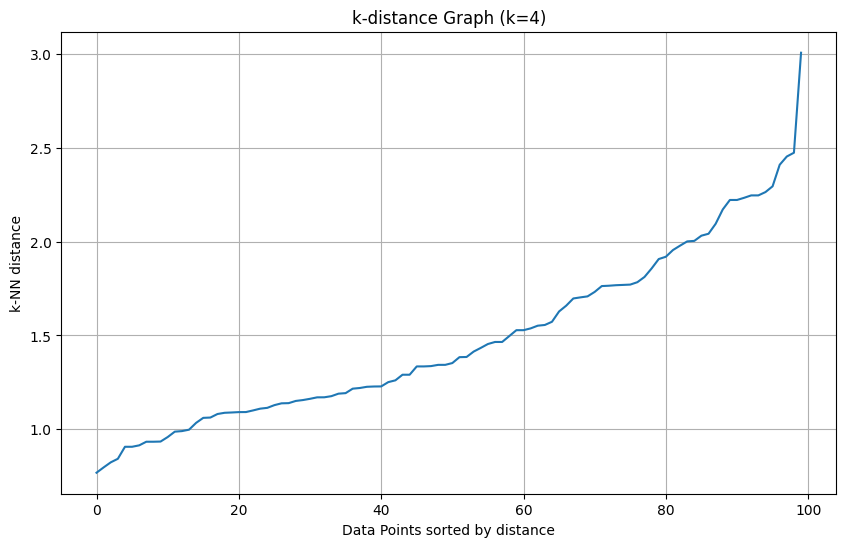

Distance values at different percentiles:
70th percentile: 1.732
80th percentile: 1.919
90th percentile: 2.222
95th percentile: 2.295


In [93]:
# Calculate k-distance plot to find optimal eps
k = 4  # Start with min_samples - 1
nbrs = NearestNeighbors(n_neighbors=k).fit(X_scaled)
distances, indices = nbrs.kneighbors(X_scaled)

# Sort distances to k-th nearest neighbor
distances = np.sort(distances[:, k-1], axis=0)

# Plot k-distance graph
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.ylabel('k-NN distance')
plt.xlabel('Data Points sorted by distance')
plt.title('k-distance Graph (k=4)')
plt.grid(True)
plt.show()

# Print some distance values to help identify elbow
print("Distance values at different percentiles:")
for pct in [70, 80, 90, 95]:
    idx = int(len(distances) * pct/100)
    print(f"{pct}th percentile: {distances[idx]:.3f}")

In [94]:
# Test HIGHER eps values based on your k-distance results
eps_values = [1.4, 1.6, 1.8, 2.0, 2.2, 2.4]
min_samples_values = [3, 4, 5]

print("DBSCAN Parameter Testing (Adjusted Range):")
print("=" * 45)

for min_samp in min_samples_values:
    print(f"\n--- min_samples = {min_samp} ---")
    for eps in eps_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samp)
        clusters = dbscan.fit_predict(X_scaled)
        
        n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
        n_noise = list(clusters).count(-1)
        
        print(f"eps={eps}: {n_clusters} clusters, {n_noise} noise points")

DBSCAN Parameter Testing (Adjusted Range):

--- min_samples = 3 ---
eps=1.4: 3 clusters, 28 noise points
eps=1.6: 1 clusters, 17 noise points
eps=1.8: 1 clusters, 11 noise points
eps=2.0: 1 clusters, 6 noise points
eps=2.2: 1 clusters, 2 noise points
eps=2.4: 1 clusters, 1 noise points

--- min_samples = 4 ---
eps=1.4: 2 clusters, 33 noise points
eps=1.6: 1 clusters, 23 noise points
eps=1.8: 1 clusters, 13 noise points
eps=2.0: 1 clusters, 8 noise points
eps=2.2: 1 clusters, 2 noise points
eps=2.4: 1 clusters, 1 noise points

--- min_samples = 5 ---
eps=1.4: 1 clusters, 40 noise points
eps=1.6: 1 clusters, 28 noise points
eps=1.8: 1 clusters, 14 noise points
eps=2.0: 1 clusters, 8 noise points
eps=2.2: 1 clusters, 2 noise points
eps=2.4: 1 clusters, 1 noise points


In [95]:
# Apply best parameters
best_dbscan = DBSCAN(eps=1.4, min_samples=3)
clusters = best_dbscan.fit_predict(X_scaled)

# Add clusters back to original dataframe
cm_clean['cluster'] = clusters

# Show cluster summary
print("Cluster Summary:")
print("================")
cluster_counts = pd.Series(clusters).value_counts().sort_index()
print(cluster_counts)

print(f"\nFound {len(set(clusters))-1} clusters with {list(clusters).count(-1)} noise points")

# Analyze each cluster using original scale values
print("\nCluster Characteristics (Original Scale):")
print("=" * 50)

for cluster_id in [0, 1, 2]:  # 3 clusters
    cluster_players = cm_clean[cm_clean['cluster'] == cluster_id]
    print(f"\n--- Cluster {cluster_id}: {len(cluster_players)} players ---")
    print(cluster_players[cm_features].mean().round(2))

# Show noise points (unique players)
noise_players = cm_clean[cm_clean['cluster'] == -1]
print(f"\n--- Noise Points: {len(noise_players)} unique players ---")
if 'Player' in cm_clean.columns:  # If you have player names
    print(noise_players['Player'].tolist())

Cluster Summary:
-1    28
 0    65
 1     4
 2     3
Name: count, dtype: int64

Found 3 clusters with 28 noise points

Cluster Characteristics (Original Scale):

--- Cluster 0: 65 players ---
EFx Ground Duels            4.28
EFx Prog. Pass              3.72
Accurate passes, %         87.06
Progressive runs per 90     0.97
Key passes per 90           0.22
Touches in box per 90       0.91
dtype: float64

--- Cluster 1: 4 players ---
EFx Ground Duels            1.96
EFx Prog. Pass              3.43
Accurate passes, %         90.62
Progressive runs per 90     2.05
Key passes per 90           0.42
Touches in box per 90       2.52
dtype: float64

--- Cluster 2: 3 players ---
EFx Ground Duels            3.18
EFx Prog. Pass              2.40
Accurate passes, %         75.63
Progressive runs per 90     2.68
Key passes per 90           0.45
Touches in box per 90       3.59
dtype: float64

--- Noise Points: 28 unique players ---


K-means Parameter Testing:
k=3: Inertia=348.43, Silhouette Score=0.252
k=4: Inertia=302.43, Silhouette Score=0.191
k=5: Inertia=268.23, Silhouette Score=0.187
k=6: Inertia=236.55, Silhouette Score=0.200


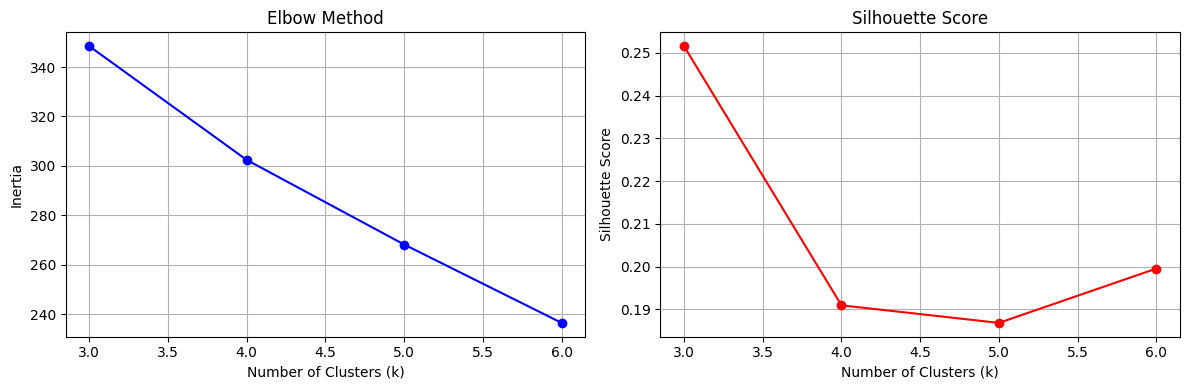


Best silhouette score: k=3


In [96]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Test different k values
k_values = [3, 4, 5, 6]
inertias = []
silhouette_scores = []

print("K-means Parameter Testing:")
print("=" * 30)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_scaled)
    
    inertia = kmeans.inertia_
    sil_score = silhouette_score(X_scaled, cluster_labels)
    
    inertias.append(inertia)
    silhouette_scores.append(sil_score)
    
    print(f"k={k}: Inertia={inertia:.2f}, Silhouette Score={sil_score:.3f}")

# Plot elbow curve
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(k_values, inertias, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(k_values, silhouette_scores, 'ro-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score')
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"\nBest silhouette score: k={k_values[silhouette_scores.index(max(silhouette_scores))]}")

In [98]:

best_k = 3  # We'll decide based on above results
kmeans_best = KMeans(n_clusters=best_k, random_state=42, n_init=10)
kmeans_clusters = kmeans_best.fit_predict(X_scaled)

cm_clean['kmeans_cluster'] = kmeans_clusters

# Compare cluster sizes
print("Cluster Size Comparison:")
print("=" * 25)
print("DBSCAN:", pd.Series(clusters).value_counts().sort_index())
print("K-means:", pd.Series(kmeans_clusters).value_counts().sort_index())

Cluster Size Comparison:
DBSCAN: -1    28
 0    65
 1     4
 2     3
Name: count, dtype: int64
K-means: 0    21
1    21
2    58
Name: count, dtype: int64


In [99]:
print("DETAILED CLUSTER COMPARISON:")
print("=" * 50)

print("\n🔸 DBSCAN Results (eps=1.4, min_samples=3):")
print("-" * 45)
for cluster_id in [0, 1, 2]:
    cluster_players = cm_clean[cm_clean['cluster'] == cluster_id]
    print(f"\nDBSCAN Cluster {cluster_id}: {len(cluster_players)} players")
    print(cluster_players[cm_features].mean().round(2))

print(f"\nDBSCAN Noise: {(clusters == -1).sum()} unique players")

print("\n🔸 K-means Results (k=3):")
print("-" * 35)
for cluster_id in [0, 1, 2]:
    cluster_players = cm_clean[cm_clean['kmeans_cluster'] == cluster_id]
    print(f"\nK-means Cluster {cluster_id}: {len(cluster_players)} players")
    print(cluster_players[cm_features].mean().round(2))

DETAILED CLUSTER COMPARISON:

🔸 DBSCAN Results (eps=1.4, min_samples=3):
---------------------------------------------

DBSCAN Cluster 0: 65 players
EFx Ground Duels            4.28
EFx Prog. Pass              3.72
Accurate passes, %         87.06
Progressive runs per 90     0.97
Key passes per 90           0.22
Touches in box per 90       0.91
dtype: float64

DBSCAN Cluster 1: 4 players
EFx Ground Duels            1.96
EFx Prog. Pass              3.43
Accurate passes, %         90.62
Progressive runs per 90     2.05
Key passes per 90           0.42
Touches in box per 90       2.52
dtype: float64

DBSCAN Cluster 2: 3 players
EFx Ground Duels            3.18
EFx Prog. Pass              2.40
Accurate passes, %         75.63
Progressive runs per 90     2.68
Key passes per 90           0.45
Touches in box per 90       3.59
dtype: float64

DBSCAN Noise: 28 unique players

🔸 K-means Results (k=3):
-----------------------------------

K-means Cluster 0: 21 players
EFx Ground Duels            